# White
QC

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE208152

## 0. Setting up workenvironment<a id="0"></a>

In [1]:
suppressPackageStartupMessages({
    library(DropletUtils)
    library(SingleCellExperiment)
    library(scuttle)
    library(Seurat)
    library(SeuratWrappers)
    library(stringr)
    library(dplyr)
    library(data.table)
    library(Matrix)
    library(patchwork)
    library(ggplot2)
})

options(repr.plot.width = 16, repr.plot.height = 8)

## 1. Importing data<a id="1"></a>


In [2]:
seurat.data <- Read10X(data.dir = "/home/host_home/Documents/Tom/Atlas/data/SCA_core/White/raw_data/")
seurat <- CreateSeuratObject(counts = seurat.data)
rm(seurat.data)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


## 2. Preprocessing: quality control with scater<a id="4"></a>

### 2.1. RD3_1

#### 2.1.1. Converting a Seurat object to SingleCellExperiment 

In [3]:
sce <- as.SingleCellExperiment(seurat)

#### 2.1.2. Calculating QC metrics

In [5]:
is.mito <- grepl("^mt-", rownames(sce))
mito.list <-  grep("^mt-", rownames(sce), value = TRUE)

In [7]:
mito.list

[1] "mt-Tf"   "mt-Rnr1" "mt-Tv"   "mt-Rnr2" "mt-Tl1"  "mt-Nd1"  "mt-Ti"  
 [8] "mt-Tq"   "mt-Tm"   "mt-Nd2"  "mt-Tw"   "mt-Ta"   "mt-Tn"   "mt-Tc"  
[15] "mt-Ty"   "mt-Co1"  "mt-Ts1"  "mt-Td"   "mt-Co2"  "mt-Tk"   "mt-Atp8"
[22] "mt-Atp6" "mt-Co3"  "mt-Tg"   "mt-Nd3"  "mt-Tr"   "mt-Nd4l" "mt-Nd4" 
[29] "mt-Th"   "mt-Ts2"  "mt-Tl2"  "mt-Nd5"  "mt-Nd6"  "mt-Te"   "mt-Cytb"
[36] "mt-Tt"   "mt-Tp"

In [6]:
is.spike <- grepl("^gSpikein", rownames(sce))
spike.list <- grep("^gSpikein", rownames(sce), value = TRUE)

In [8]:
celldata <- perCellQCMetrics(sce, subsets = list(Mt = is.mito, ERCC = is.spike))

In [9]:
sce <- addPerCellQC(sce, subsets=list(Mito = is.mito, ERCC = is.spike))
colnames(colData(sce))

[1] "orig.ident"            "nCount_RNA"            "nFeature_RNA"         
 [4] "ident"                 "sum"                   "detected"             
 [7] "subsets_Mito_sum"      "subsets_Mito_detected" "subsets_Mito_percent" 
[10] "subsets_ERCC_sum"      "subsets_ERCC_detected" "subsets_ERCC_percent" 
[13] "total"

Expression of all ERCC spikeins is 0 because they were not used in this study.

##### **2.1.2.1. QC of the cells by feature number and library size**


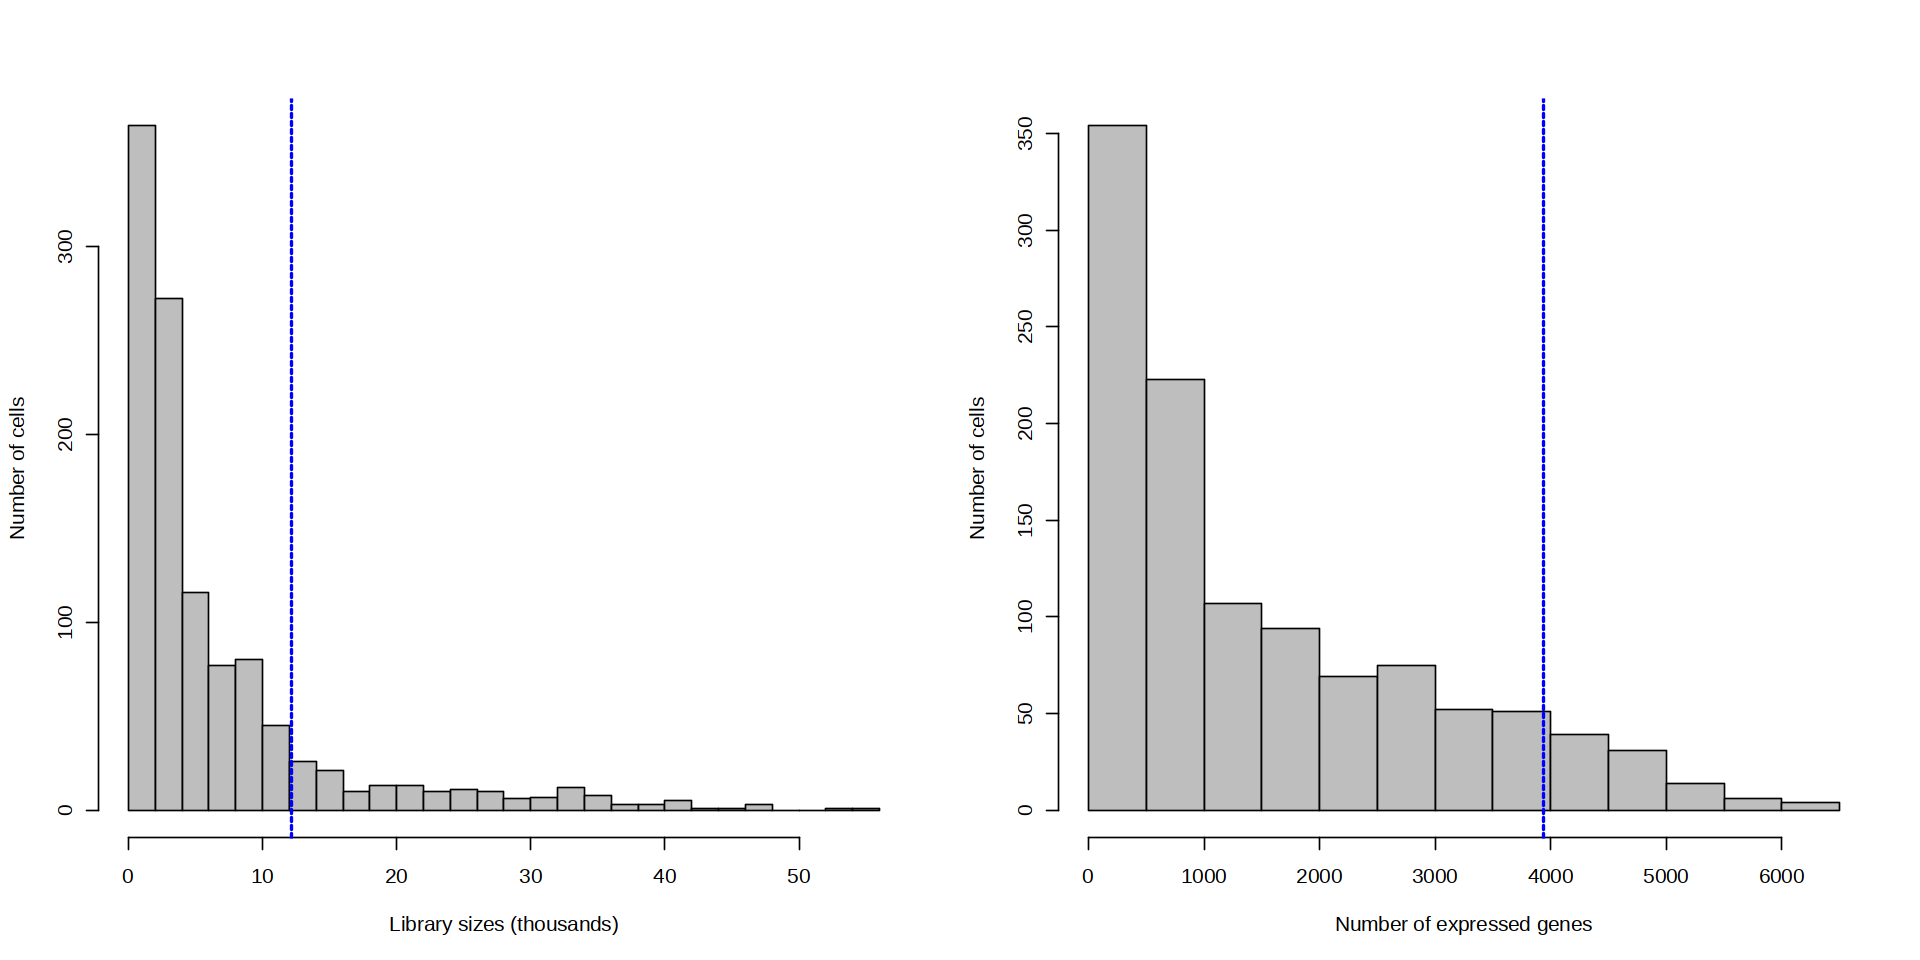

In [10]:
libsize.drop <- isOutlier(sce$sum, nmads = 3, type = "both", log = TRUE)
feature.drop <- isOutlier(sce$detected, nmads = 3, type = "both", log = TRUE)

# libsize.drop cutoff values
min.libsize <- (median(sce$sum) - 3*mad(sce$sum))/1e3
max.libsize <- (median(sce$sum) + 3*mad(sce$sum))/1e3

# feature.drop cutoff values
min.features <- (median(sce$detected) - 3*mad(sce$detected))
max.features <- (median(sce$detected) + 3*mad(sce$detected))

par(mfrow = c(1,2))

hist(sce$sum/1e3, xlab = "Library sizes (thousands)", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")

abline(v = min.libsize, col = "blue", lwd = 2, lty = 2)
abline(v = max.libsize, col = "blue", lwd = 2, lty = 2)

hist(sce$detected, xlab = "Number of expressed genes", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")

abline(v = min.features, col = "blue", lwd = 2, lty = 2)
abline(v = max.features, col = "blue", lwd = 2, lty = 2)

##### **2.1.2.2. Proportion of mitochondrial reads**


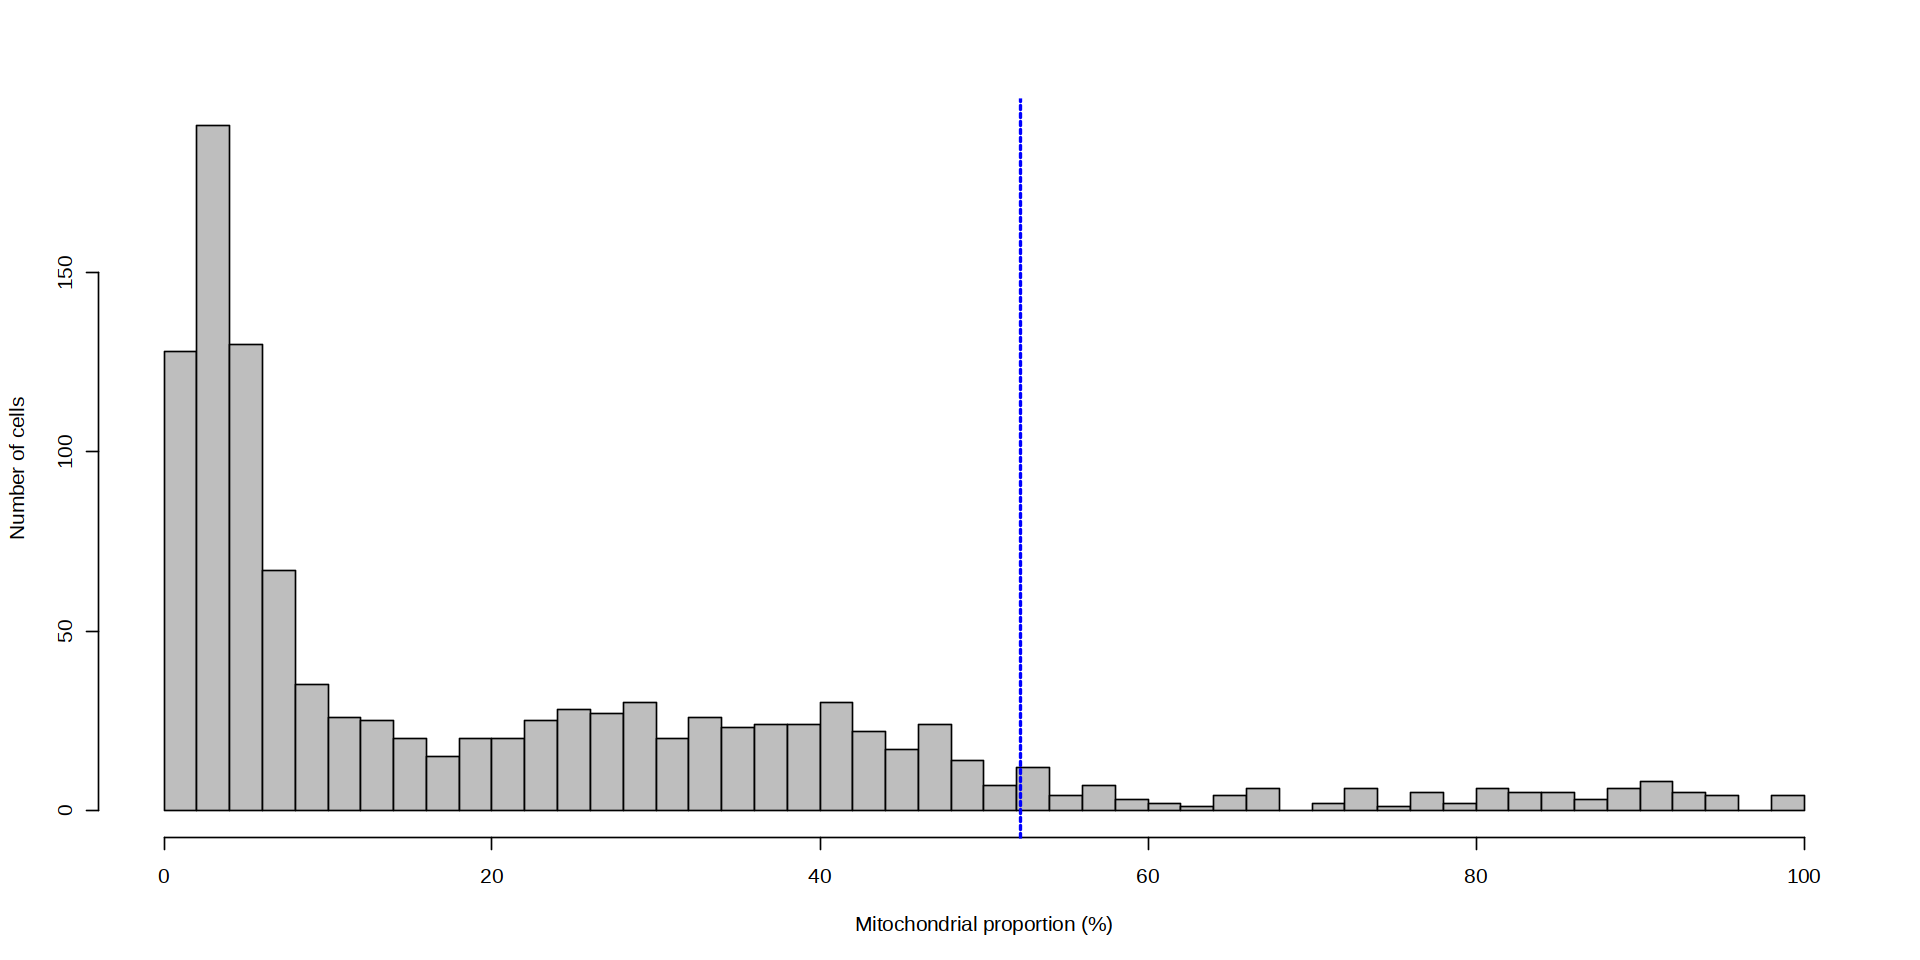

In [12]:
mito.drop <- isOutlier(sce$subsets_Mito_percent, nmads = 3)

max.mito <- median(sce$subsets_Mito_percent) + 3*mad(sce$subsets_Mito_percent)

hist(sce$subsets_Mito_percent, xlab = "Mitochondrial proportion (%)",
     ylab = "Number of cells",
     breaks = 40, main = "", col = "grey")

abline(v = max.mito, col = "blue", lwd = 2, lty = 2)

Subset by column to retain only high-quality cells that pass all filters.

In [14]:
sce_QC <- sce[,!(libsize.drop | feature.drop | mito.drop)]
data.frame(ByLibrarySize = sum(libsize.drop), ByFeature = sum(feature.drop), ByMito = sum(mito.drop),
           Remaining = ncol(sce_QC))

ByLibrarySize,ByFeature,ByMito,Remaining
<int>,<int>,<int>,<int>
0,0,97,1022


#### 2.1.2. Filtering out low-abundance genes


In [15]:
average.counts <- calculateAverage(sce_QC, exprs_values = "counts",
                                   subset_row = NULL)
genes.to.keep <- average.counts >= 0.001
sum(genes.to.keep)

[1] 19742

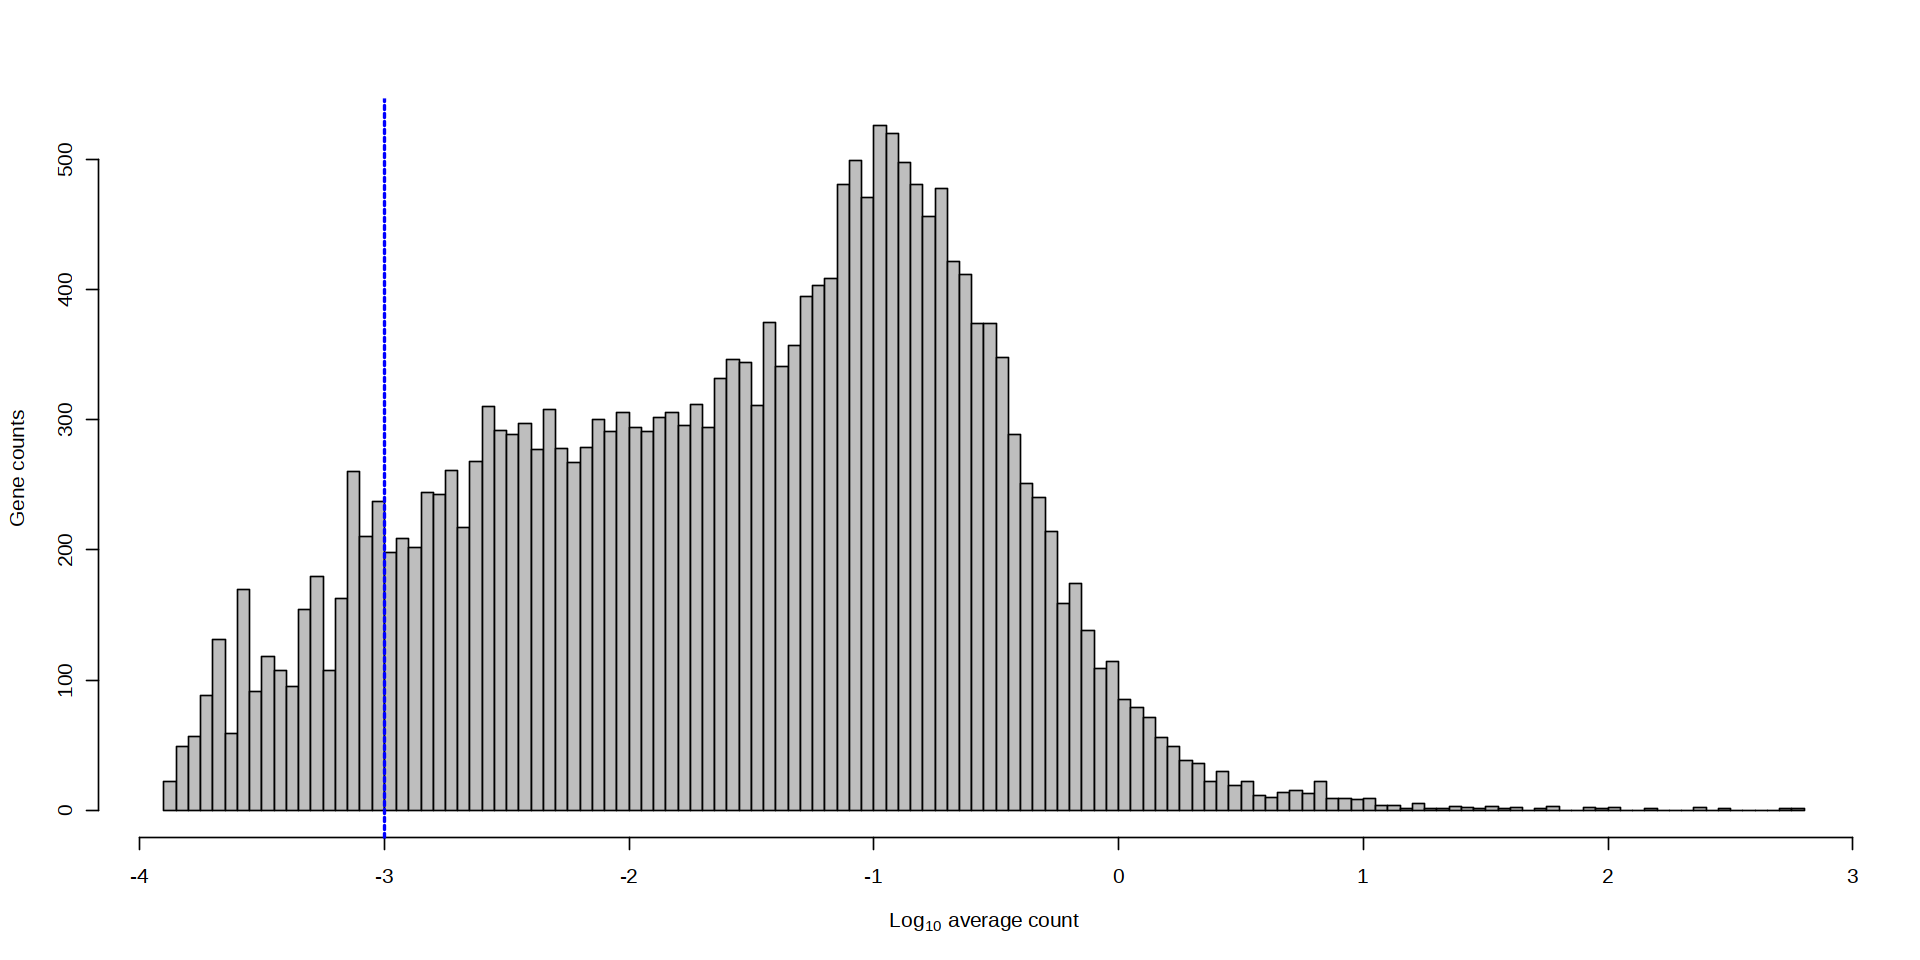

In [16]:
hist(log10(average.counts), breaks = 100, main = "", col = "grey",
     xlab = expression(Log[10]~"average count"), ylab = "Gene counts")
abline(v = log10(0.001), col = "blue", lwd = 2, lty = 2)

rm(average.counts)

Apply the mean-based filter to the data by subsetting the `SingleCellExperiment` object.

In [17]:
sce <- sce_QC[genes.to.keep,]

rm(sce_QC)

dim(sce)

[1] 19742  1022

#### 2.1.3. Duplicate removal

In [18]:
sce <- sce[!duplicated(rownames(sce)),]
dim(sce)

[1] 19742  1022

In [19]:
sce <- as.Seurat(sce)

In [20]:
sce

An object of class Seurat 
19742 features across 1022 samples within 1 assay 
Active assay: RNA (19742 features, 0 variable features)

In [22]:
saveRDS(sce, file = "/home/host_home/Documents/Tom/Atlas/data/SCA_core/White/SRP386294_QC.Rds")